In [1]:
# Uncomment only if you want to reprocess the raw data using initial_prep.py
# The script will re-create crashes.gz, comma separated gzipped file in ../data/processed

## %run ../src/preprocessing/initial_prep.py

In [2]:
%run ../src/import_libraries.py

%matplotlib inline

In [3]:

full_df=pd.read_csv('../data/processed/crashes.gz', compression='gzip', low_memory=False)

In [4]:
sample_df=full_df.sample(100000, random_state=100)
#sample_df=full_df.copy()


y = sample_df['GUILTY']
x = sample_df.drop(['GUILTY'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=100, test_size=0.25, stratify=y)


In [5]:
numeric_columns = []
nominal_columns = [ 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 'MANEUVER', 'PHYSICAL_CONDITION', 'TRAFFIC_CONTROL_DEVICE', 'VEHICLE_DEFECT']


X_train = X_train[numeric_columns+nominal_columns]
X_test = X_test[numeric_columns+nominal_columns]



# Defining Pipeline


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
cat_pipeline = Pipeline([
        ('cat_encoder', OneHotEncoder(sparse=False, handle_unknown =  'ignore' )),
         ('std_scaler', StandardScaler()),
    
    ])


fu = FeatureUnion(transformer_list=[
        ("cat_pipeline", cat_pipeline),
    ])

# Voting Ensemble

In [7]:
logreg = LogisticRegression( max_iter=5000, class_weight='balanced')
extra = ExtraTreesClassifier( max_depth=13, min_samples_leaf=3, min_samples_split=6, n_estimators=200, class_weight='balanced' )
rand = RandomForestClassifier( min_samples_leaf=8, n_estimators=200, class_weight='balanced' )
dtree = DecisionTreeClassifier(criterion='entropy', random_state=100, class_weight='balanced')
naive = QuadraticDiscriminantAnalysis()
knn = KNeighborsClassifier( n_jobs=-1 , n_neighbors=120, weights='uniform', p=1)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', gamma= 0.01, max_depth=3, n_estimators=90, n_jobs=-1)


vote_pipe = Pipeline([('fu', fu),
                      ('model', VotingClassifier(estimators = [
#                                                 ('logreg',logreg), 
                                                 ('extra',extra), 
                                                 ('rand',rand),
                                                 ('dtree',dtree), 
                                                 ('naive',naive),
                                                  ('knn',knn),
                                                  ('xgb',xgb ),
                                                  ], voting='hard'))   
                     ])




In [8]:
pipe_grid = {}

gs_pipe = GridSearchCV(estimator=vote_pipe, 
                       param_grid=pipe_grid, cv=2, scoring='accuracy')



In [9]:
vote_pipe.fit(X_train, y_train)
#gs_pipe.fit(X_train, y_train)


Pipeline(steps=[('fu',
                 FeatureUnion(transformer_list=[('cat_pipeline',
                                                 Pipeline(steps=[('cat_encoder',
                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                sparse=False)),
                                                                 ('std_scaler',
                                                                  StandardScaler())]))])),
                ('model',
                 VotingClassifier(estimators=[('extra',
                                               ExtraTreesClassifier(class_weight='balanced',
                                                                    max_depth=13,
                                                                    min_samples_leaf=3,
                                                                    min_samples_split=6,
                                                                    n_estimators=20...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=3,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=90,
                                                             n_jobs=-1,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None,
                                                             reg_alpha=None,
                                                             reg_lambda=None, ...))]))])

In [10]:
#y_pred_train=gs_pipe.predict(X_train)
#y_pred_test=gs_pipe.predict(X_test)
y_pred_test=vote_pipe.predict(X_test)

In [11]:
#gs_pipe.score(X_train, y_train)

In [12]:
#print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))

------------
              precision    recall  f1-score   support

           0       0.85      0.79      0.82     16124
           1       0.67      0.75      0.71      8876

    accuracy                           0.78     25000
   macro avg       0.76      0.77      0.77     25000
weighted avg       0.79      0.78      0.78     25000



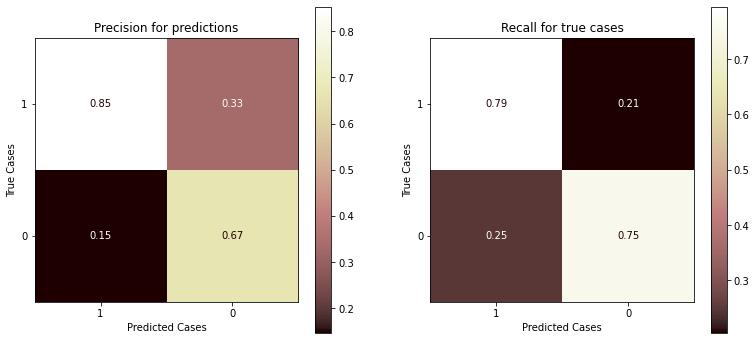

In [13]:
fig, ax = plt.subplots(figsize=(13,6), ncols=2)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='pred', 
                                        display_labels=[1,0],cmap='pink', ax=ax[0])


ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='true', 
                                        display_labels=[1,0],cmap='pink', ax=ax[1]);

ax[0].set_title("Precision for predictions")
ax[1].set_title("Recall for true cases")

ax[0].set_xlabel('Predicted Cases')
ax[0].set_ylabel('True Cases')
ax[1].set_xlabel('Predicted Cases')
ax[1].set_ylabel('True Cases');

# XGBoost

In [29]:
XGB_pipeline = Pipeline([ ( "cat_pipeline", cat_pipeline ),
                  ('boost', XGBClassifier(use_label_encoder=False, 
                                          eval_metric='auc', gamma= 0.02, max_depth=3, n_estimators=90, n_jobs=-1))
                 ])


#pipe_grid={'boost__gamma':[0.01,0.015]}
pipe_grid={'boost__max_depth':[2,3,4,5,6,7,8], 'boost__n_estimators':[250,300, 350]}

gs_pipe = GridSearchCV(estimator=XGB_pipeline, param_grid=pipe_grid,  cv=3, scoring='roc_auc')


In [30]:
gs_pipe.fit(X_train, y_train)
y_pred_train=gs_pipe.predict(X_train)
y_pred_test=gs_pipe.predict(X_test)

In [31]:
gs_pipe.best_params_

{'boost__max_depth': 3, 'boost__n_estimators': 350}

In [32]:
#print(XGB_pipeline.score(X_train, y_train ))
print(gs_pipe.score(X_train, y_train ))
print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))

0.8512554232609459
              precision    recall  f1-score   support

           0       0.82      0.87      0.84     48373
           1       0.73      0.65      0.69     26627

    accuracy                           0.79     75000
   macro avg       0.78      0.76      0.77     75000
weighted avg       0.79      0.79      0.79     75000

------------
              precision    recall  f1-score   support

           0       0.82      0.87      0.84     16124
           1       0.72      0.64      0.68      8876

    accuracy                           0.79     25000
   macro avg       0.77      0.75      0.76     25000
weighted avg       0.78      0.79      0.78     25000



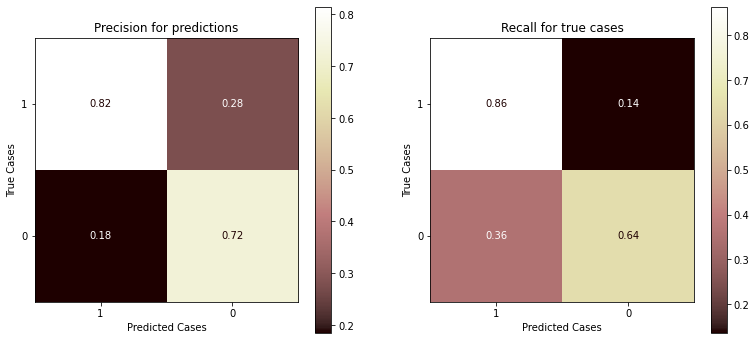

In [17]:
fig, ax = plt.subplots(figsize=(13,6), ncols=2)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='pred', 
                                        display_labels=[1,0],cmap='pink', ax=ax[0])


ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='true', 
                                        display_labels=[1,0],cmap='pink', ax=ax[1]);

ax[0].set_title("Precision for predictions")
ax[1].set_title("Recall for true cases")

ax[0].set_xlabel('Predicted Cases')
ax[0].set_ylabel('True Cases')
ax[1].set_xlabel('Predicted Cases')
ax[1].set_ylabel('True Cases');